<a href="https://colab.research.google.com/github/lechurnair/TempQA/blob/main/QA_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers tensorflow numpy
!pip install sentencepiece

In [ ]:
from transformers import BertTokenizer, TFBertForMaskedLM, BertForQuestionAnswering
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import random
from google.colab import drive
import re
import nltk
import torch
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from transformers import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
import json
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.2 MB/s eta 0:00:00


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForMaskedLM.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [ ]:
from datasets import load_dataset


In [ ]:
dataset = load_dataset('mc_taco')

Generating test split:   0%|          | 0/9442 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3783 [00:00<?, ? examples/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})


In [ ]:
# Event ordering and stationary cant be predicted in our model, so removing that data (category : 1,4 )

updated_dataset = dict()

updated_dataset['test'] = [x for x in dataset['test']  if (x['label']!=0)]
updated_dataset['validation'] = [x for x in dataset['validation'] if (x['label']!=0)]

# 2239 test and 826 validation

In [ ]:
def CommonSenseType(x):
  if(x == 0):
    return "Event Duration"
  if(x == 1):
    return "Event Ordering"
  if(x == 2):
    return "Frequency"
  if(x == 3):
    return "Typical Time"
  if(x == 4):
    return "Stationarity"

In [ ]:
training_data = [x['sentence']+' '+x['question']+' : '+x['answer']+ ' ('+CommonSenseType(x['category'])+')' for x in updated_dataset['test']]
test_data =  [x['sentence']+' '+x['question']+' : '+x['answer']+ ' ('+CommonSenseType(x['category'])+')' for x in updated_dataset['validation']]

inputs = tokenizer(training_data,max_length=100,truncation=True,padding='max_length',return_tensors='tf')
inputs['labels'] = inputs['input_ids']


In [ ]:
mask_token_id = tokenizer.convert_tokens_to_ids('[MASK]')
num_tokens_to_replace = 2
training_data_updated = list()
for i in updated_dataset['test']:
  mask_answer = random.randint(0, 1)
  if mask_answer:
    answer_length = len(tokenizer.tokenize(i['answer']))
    training_data_updated.append(i['sentence']+' '+i['question']+' : '+answer_length*('[MASK]')+ ' ('+CommonSenseType(i['category'])+')')
  else:
    token_length = len(tokenizer.tokenize(CommonSenseType(i['category'])))
    training_data_updated.append(i['sentence']+' '+i['question']+' : '+i['answer']+' ('+token_length*('[MASK]')+')')

inputs_updated = tokenizer(training_data_updated,max_length=100,truncation=True,padding='max_length',return_tensors='tf')
inputs['input_ids'] = inputs_updated['input_ids']
print(inputs['input_ids'][0])


tf.Tensor(
[  101  4241 14544  1005  1055  2269  2351  1999  5018  2475  1010  1998
  2010  2388  2351  1999 16528  2509  1012  2129  2146  2001  2010  2388
  5665  1029  1024  1020  2706  1006   103   103  1007   102     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(100,), dtype=int32)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Training the model



In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

checkpoint_file_path = '/content/drive/My Drive/checkpoints/model_latest_checkpoint.h1'

model = TFBertForMaskedLM.from_pretrained('bert-base-uncased')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_file_path, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    [inputs.input_ids, inputs.attention_mask],
    inputs.labels,
    verbose=1,
    batch_size=8,
    epochs=10,
    validation_split=0.2,
    callbacks=[checkpoint_callback, early_stopping_callback]
)
model.save_pretrained('/content/drive/My Drive/checkpoints/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Epoch 1/10
320/320 [==============================] - ETA: 0s - loss: 0.2519 
Epoch 1: val_loss improved from inf to 0.08612, saving model to /content/drive/My Drive/checkpoints/model_latest_checkpoint.h1
320/320 [==============================] - 4919s 15s/step - loss: 0.2519 - val_loss: 0.0861
Epoch 2/10
320/320 [==============================] - ETA: 0s - loss: 0.0635 
Epoch 2: val_loss improved from 0.08612 to 0.08396, saving model to /content/drive/My Drive/checkpoints/model_latest_checkpoint.h1
320/320 [==============================] - 4843s 15s/step - loss: 0.0635 - val_loss: 0.0840
Epoch 3/10
320/320 [==============================] - ETA: 0s - loss: 0.0489 
Epoch 3: val_loss did not improve from 0.08396
320/320 [==============================] - 4836s 15s/step - loss: 0.0489 - val_loss: 0.0893
Epoch 4/10
320/320 [==============================] - ETA: 0s - loss: 0.0399 
Epoch 4: val_loss did not improve from 0.08396
320/320 [==============================] - 4804s 15s/step - 

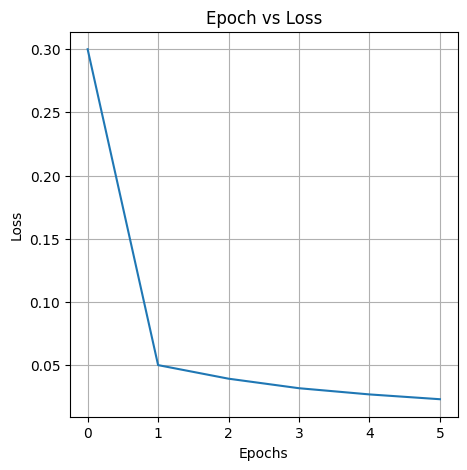

In [ ]:
losses = history.history['loss']
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
ax1.plot(range(len(losses)),losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Epoch vs Loss")
plt.grid()
plt.show()

In [ ]:
import random
import os
import re
from google.colab import drive
drive.mount('/content/drive')

checkpoint_file_path = '/content/drive/My Drive/checkpoints/model_latest_checkpoint.h1'

model = tf.keras.models.load_model(checkpoint_file_path)

count=0
total=0

for i in range(len(updated_dataset['validation'])):
  test_example = updated_dataset['validation'][i]

  sentence = test_example['sentence']
  question = test_example['question']
  answer = test_example['answer']
  category = CommonSenseType(test_example['category'])

  mask_answer = random.choice([True, False])

  mask_answer=0

  if mask_answer:
      query = sentence + ' ' + question + ' : ' + len(tokenizer.tokenize(answer)) * '[MASK]' + ' (' + CommonSenseType(test_example['category']) + ')'
  else:
      query = sentence + ' ' + question + ' : ' + answer + ' (' + len(tokenizer.tokenize(CommonSenseType(test_example['category']))) * '[MASK]' + ')'

  inputs = tokenizer(query, return_tensors="tf")

  with tf.device('/cpu:0'):
      outputs = model(inputs)

  predicted_token_ids = tf.argmax(outputs['logits'], axis=-1)

  predicted_text = tokenizer.decode(predicted_token_ids[0].numpy(), skip_special_tokens=True)

  pattern = r'\(([^)]+)\)'

  matches = re.findall(pattern, predicted_text)

  cat = None
  if matches:
      cat = matches[0].strip()
  total+=1
  if(category.lower()==cat.lower()):
    count+=1

print(count)
print(total)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1197
1229


In [ ]:
checkpoint_file_path = '/content/drive/My Drive/checkpoints/model_latest_checkpoint.h1'

model = tf.keras.models.load_model(checkpoint_file_path)
answer_dict=dict()
event_dict=dict()
time_dict=dict()
freq_dict=dict()
order_dict=dict()
stat_dict=dict()

for i in range(len(updated_dataset['validation'])):
  test_example = updated_dataset['validation'][i]

  sentence = test_example['sentence']
  question = test_example['question']
  answer = test_example['answer']
  category = CommonSenseType(test_example['category'])

  mask_answer = random.choice([True, False])

  mask_answer=1

  if mask_answer:
      query = sentence + ' ' + question + ' : ' + len(tokenizer.tokenize(answer)) * '[MASK]' + ' (' + CommonSenseType(test_example['category']) + ')'
  else:
      query = sentence + ' ' + question + ' : ' + answer + ' (' + len(tokenizer.tokenize(CommonSenseType(test_example['category']))) * '[MASK]' + ')'

  inputs = tokenizer(query, return_tensors="tf")

  with tf.device('/cpu:0'):
      outputs = model(inputs)

  predicted_token_ids = tf.argmax(outputs['logits'], axis=-1)

  predicted_text = tokenizer.decode(predicted_token_ids[0].numpy(), skip_special_tokens=True)
  sentences = sent_tokenize(predicted_text)

  answer_text = None
  cat = None

  for sentence in sentences:
      category_match = re.search(r'\(([^)]+)\)', sentence)
      if category_match:
          cat = category_match.group(1)
          sentence = sentence.replace(category_match.group(0), '')

      if sentence.strip():
          answer_text = sentence.strip().replace(':', '')

  answer_text=answer_text.strip()
  if(category.strip()=='Event Duration'):
    event_dict[question]=[answer, answer_text]
  elif(category.strip()=='Typical Time'):
    time_dict[question]=[answer, answer_text]
  elif(category.strip()=='Event Ordering'):
    order_dict[question]=[answer, answer_text]
  elif(category.strip()=='Stationarity'):
    stat_dict[question]=[answer, answer_text]
  else:
    freq_dict[question]=[answer, answer_text]

In [ ]:
import random
import os
from google.colab import drive
drive.mount('/content/drive')

checkpoint_file_path = '/content/drive/My Drive/checkpoints/model_latest_checkpoint.h1'

model = tf.keras.models.load_model(checkpoint_file_path)

test_example = updated_dataset['validation'][329]

sentence = test_example['sentence']
question = test_example['question']
answer = test_example['answer']
category = CommonSenseType(test_example['category'])

mask_answer = random.choice([True, False])

mask_answer=1

if mask_answer:
    query = sentence + ' ' + question + ' : ' + len(tokenizer.tokenize(answer)) * '[MASK]' + ' (' + CommonSenseType(test_example['category']) + ')'
else:
    query = sentence + ' ' + question + ' : ' + answer + ' (' + len(tokenizer.tokenize(CommonSenseType(test_example['category']))) * '[MASK]' + ')'

print("Query:")
print(query+'\n')

print('Answer:')
print(answer+'\n')

print('Category:')
print(category+'\n')

inputs = tokenizer(query, return_tensors="tf")

with tf.device('/cpu:0'):
    outputs = model(inputs)

predicted_token_ids = tf.argmax(outputs['logits'], axis=-1)

predicted_text = tokenizer.decode(predicted_token_ids[0].numpy(), skip_special_tokens=True)

print("Predicted Text:")
print(predicted_text)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Query:
He would splash and play until he was ready to go back home, where he would sleep for hours, having worn himself out playing. How long would he splash and play for? : [MASK][MASK] (Event Duration)

Answer:
1 hour

Category:
Event Duration

Predicted Text:
he would splash and play until he was ready to go back home, where he would sleep for hours, having worn himself out playing. how long would he splash and play for? : a minutes ( event duration )


In [ ]:
import re
import nltk
from nltk.tokenize import sent_tokenize

sentences = sent_tokenize(predicted_text)

answer_text = None
category = None

for sentence in sentences:
    category_match = re.search(r'\(([^)]+)\)', sentence)
    if category_match:
        category = category_match.group(1)
        sentence = sentence.replace(category_match.group(0), '')

    if sentence.strip():
        answer_text = sentence.strip().replace(':', '')

answer_text=answer_text.strip()
print("Extracted Answer:", answer_text)


Extracted Answer: 2 years


In [ ]:
import re

pattern = r'\(([^)]+)\)'

matches = re.findall(pattern, predicted_text)

if matches:
    cat = matches[0].strip()

print("Extracted Category:", cat)
print(category.lower()==cat.lower())

In [ ]:
print(len(updated_dataset['test']))